<a href="https://colab.research.google.com/github/open-mmlab/mmsegmentation/blob/master/demo/MMSegmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMSegmentation 教程

本教程中，我们将会展示：
* 如何应用 MMSeg 加载预训练权重，实现推理计算
* 如何训练自由数据集，并进行可视化

## 安装 MMSegmentation

In [1]:
# 检查平台上 PyTorch 版本
!pip list | grep torch

torch                         1.8.1+cu101   
torchsummary                  1.5.1         
torchtext                     0.9.1         
torchvision                   0.9.1+cu101   


In [2]:
# 安装 PyTorch 对应版本的 mmcv-full
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html
     |████████████████████████████████| 30.2MB 103kB/s 
     |████████████████████████████████| 194kB 37.8MB/s 


In [3]:
# 从源码安装 mmsegmentation
%cd /content
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

/content
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 2604, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 2604 (delta 1), reused 2 (delta 0), pack-reused 2597
Receiving objects: 100% (2604/2604), 4.69 MiB | 37.25 MiB/s, done.
Resolving deltas: 100% (1880/1880), done.
/content/mmsegmentation
Obtaining file:///content/mmsegmentation
  Running setup.py develop for mmsegmentation


In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.8.1+cu101 True
0.13.0


## 使用预训练分割模型完成推理

In [5]:
# 从 Model Zoo 获取 PSPNet 预训练模型的连接，下载并保存在 checkpoints 文件夹中

!mkdir checkpoints
!wget https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmsegmentation/models/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth -P checkpoints

--2021-05-14 08:25:39--  https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmsegmentation/models/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
Resolving open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)... 52.219.56.119
Connecting to open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)|52.219.56.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196205945 (187M) [application/x-www-form-urlencoded]
Saving to: ‘checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth’

pspnet_r50-d8_512x1 100%[===================>] 187.12M  15.5MB/s    in 14s     

2021-05-14 08:25:53 (13.7 MB/s) - ‘checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth’ saved [196205945/196205945]



In [6]:
# 设置配置文件和参数文件路径
config_file = 'configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py'
checkpoint_file = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

In [7]:
# 使用 Python API 构建模型
from mmseg.apis import init_segmentor
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

Use load_from_local loader


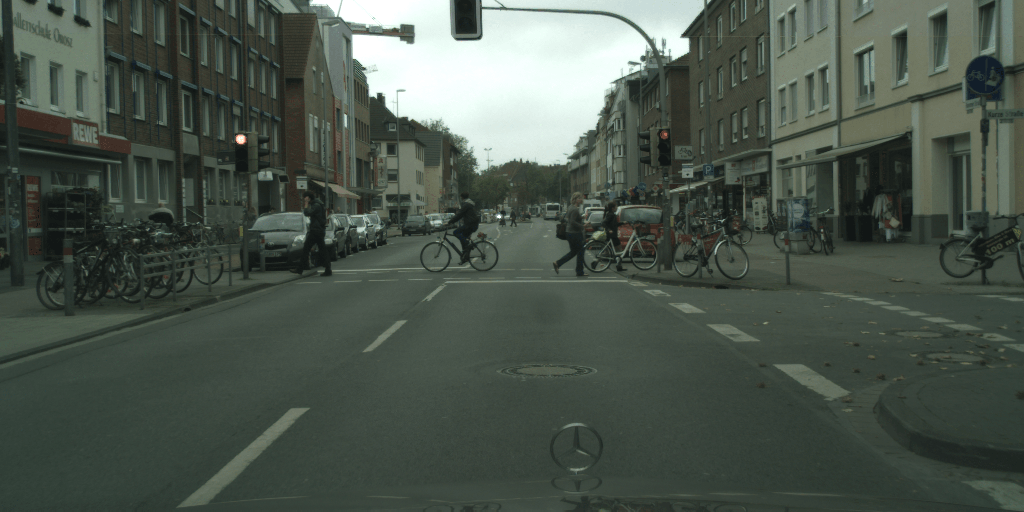

In [8]:
# 准备图像
from PIL import Image
Image.open('demo/demo.png')

In [9]:
# 调用 Python API，使用预训练模型完成推理任务
from mmseg.apis import inference_segmentor

img = 'demo/demo.png'
result = inference_segmentor(model, img)

In [10]:
result[0]

array([[2, 2, 5, ..., 2, 2, 2],
       [2, 2, 5, ..., 2, 2, 2],
       [2, 2, 5, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

/content/mmsegmentation/mmseg/models/segmentors/base.py:271: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


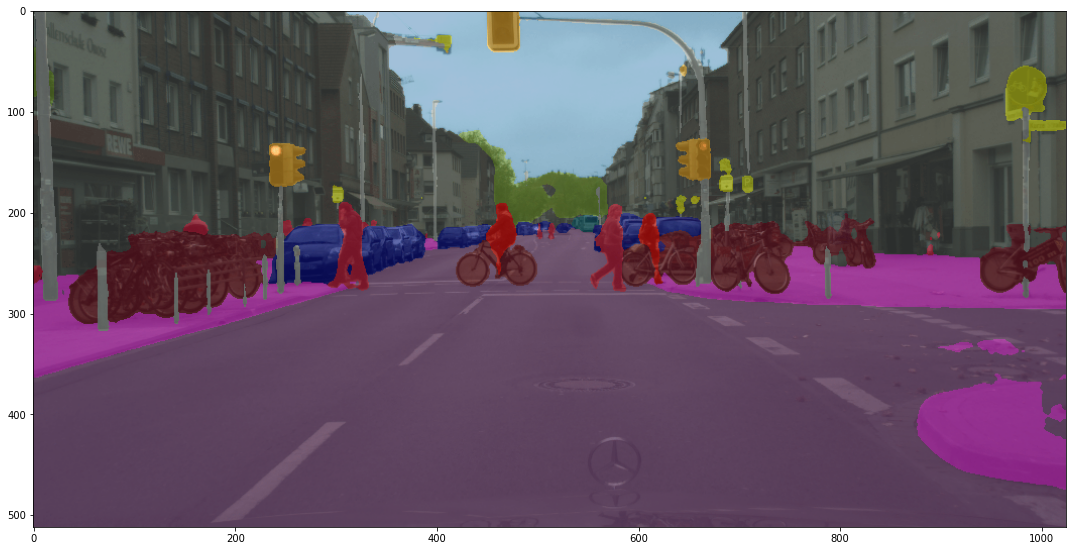

In [11]:
from mmseg.apis import show_result_pyplot
from mmseg.core.evaluation import get_palette

show_result_pyplot(model, img, result, get_palette('cityscapes'))

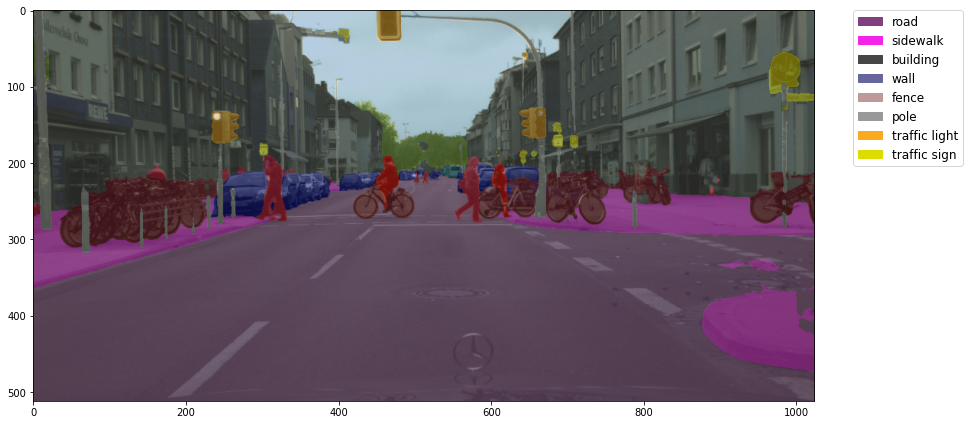

In [12]:
# 可视化分割图
from mmseg.datasets import CityscapesDataset
import numpy as np
import mmcv 

# 获取类别名和调色板
classes = CityscapesDataset.CLASSES
palette = CityscapesDataset.PALETTE

# 将分割图按调色板染色
seg_map = result[0].astype('uint8')
seg_img = Image.fromarray(seg_map).convert('P')
seg_img.putpalette(np.array(palette, dtype=np.uint8))

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
plt.figure(figsize=(14, 8))
im = plt.imshow(((np.array(seg_img.convert('RGB')))*0.4 + mmcv.imread('demo/demo.png')*0.6) / 255)

# 为每一种颜色创建一个图例
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(8)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')

plt.show()

In [ ]:
# get_palette('cityscapes')

## 在自定义数据集上训练分割模型

必要步骤：
1. 实现一个新的数据集类型
2. 对应修改配置文件
3. 启动训练和测试

### 实现新的数据集类型

在 MMSegmentation 中 Datasets 要求图像和语义分割标注需要放在同一路径的文件夹下。所以为了支持新的数据集，我们需要修改最初的文件结构。

我们提供了一个转换数据集的示例。更多细节可以参考如下链接 [docs](https://mmsegmentation.readthedocs.io/en/latest/tutorials/customize_datasets.html)

这里我们使用 [Standord Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) 作为示例。该数据集包含 715 张由 [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) 和 [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/) 这四个开源数据集中挑选出来的图片。这些图片主要是室外的场景，图像尺寸为320x240。

该数据集的标签是像分割图，一共8个类别，分别是天空 sky, 树 tree,  道路 road, 草 grass, 水 water, 建筑物 building, 山 mountain 和前景物体。

In [13]:
# 下载并解压
!wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O standford_background.tar.gz
!tar xf standford_background.tar.gz

--2021-05-14 08:31:33--  http://dags.stanford.edu/data/iccv09Data.tar.gz
Resolving dags.stanford.edu (dags.stanford.edu)... 171.64.68.10
Connecting to dags.stanford.edu (dags.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14727974 (14M) [application/x-gzip]
Saving to: ‘standford_background.tar.gz’

standford_backgroun 100%[===================>]  14.04M  10.3MB/s    in 1.4s    

2021-05-14 08:31:34 (10.3 MB/s) - ‘standford_background.tar.gz’ saved [14727974/14727974]



In [ ]:
# 接着查看数据集
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('iccv09Data/images/6000124.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

我们需要将标注转换成图像中的分割图

In [14]:
import os.path as osp
import numpy as np
from PIL import Image

# 将原始数据转换成分割图
data_root = 'iccv09Data'
img_dir = 'images'
ann_dir = 'labels'

# 定义类别名和调色板
classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]

# 对每张图像从标注转换到分割图
for file in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', '.png')))

In [ ]:
# 可视化分割图
import matplotlib.patches as mpatches
img = Image.open('iccv09Data/labels/6000124.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# 为每一种颜色创建一个图例
patches = [mpatches.Patch(color=np.array(palette[i])/255.,label=classes[i]) for i in range(8)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='large')

plt.show()

In [16]:
# 随机切分训练和验证数据集 
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # 选择前 4/5 作为训练集
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # 选择后 1/5 作为验证集
  f.writelines(line + '\n' for line in filename_list[train_length:])

在完成数据集下载之后，在新数据集 `StandfordBackgroundDataset` 中将类别名称和对应的颜色输入。

In [18]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class StandfordBackgroundDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

    

### 创建配置文件

接下来，修改配置文件进行训练。为了加速训练过程，我们使用模型微调。

In [19]:
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

上面使用的配置文件是基于 cityscapes 数据集训练的 PSPNet 模型。我们需要根据我们的新数据集对这个配置文件进行修改。

In [20]:
from mmseg.apis import set_random_seed

# 使用单个 GPU ，所以使用 BN 而非 SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

# 修改模型 decode 和 auxiliary 头中类别的数量
cfg.model.decode_head.num_classes = 8
cfg.model.auxiliary_head.num_classes = 8

# 修改 dataset_type 和路径数据路径 data_root
cfg.dataset_type = 'StandfordBackgroundDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# 使用 pspnet 的预训练模型权重
cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# 设定文件和日志保存路径 work_dir
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# 设定 seed 去辅助模型训练
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# 最后输出配置文件内容
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=8,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

### 训练和验证

In [21]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# 构建数据集
datasets = [build_dataset(cfg.data.train)]

# 构建模型
model = build_segmentor(cfg.model)

# 将类别名增加到模型中，便于进行可视化
model.CLASSES = datasets[0].CLASSES

# 创建 work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

/usr/local/lib/python3.7/dist-packages/mmcv/utils/misc.py:304: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2021-05-14 08:51:18,499 - mmseg - INFO - Loaded 572 images
2021-05-14 08:51:19,057 - mmseg - INFO - Use load_from_openmmlab loader
Downloading: "https://download.openmmlab.com/pretrain/third_party/resnet50_v1c-2cccc1ad.pth" to /root/.cache/torch/hub/checkpoints/resnet50_v1c-2cccc1ad.pth


2021-05-14 08:51:31,453 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2021-05-14 08:51:31,524 - mmseg - INFO - Loaded 143 images
2021-05-14 08:51:31,525 - mmseg - INFO - load checkpoint from checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
2021-05-14 08:51:31,527 - mmseg - INFO - Use load_from_local loader


2021-05-14 08:51:31,676 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
2021-05-14 08:51:31,679 - mmseg - INFO - Start running, host: root@54dc23ccb1d8, work_dir: /content/mmsegmentation/work_dirs/tutorial
2021-05-14 08:51:31,680 - mmseg - INFO - workflow: [('train', 1)], max: 200 iters
2021-05-14 08:51:37,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 29.6 task/s, elapsed: 5s, ETA:     0s

2021-05-14 08:53:28,489 - mmseg - INFO - per class results:
2021-05-14 08:53:28,491 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 88.62 | 93.99 |
|  tree  | 72.51 | 83.98 |
|  road  | 86.72 | 92.44 |
| grass  | 73.77 | 88.76 |
| water  | 63.69 |  70.5 |
|  bldg  | 79.61 | 90.35 |
|  mntn  |  0.0  |  0.0  |
| fg obj | 68.57 | 83.81 |
+--------+-------+-------+
2021-05-14 08:53:28,492 - mmseg - INFO - Summary:
2021-05-14 08:53:28,496 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.61 | 66.69 | 75.48 |
+-------+-------+-------+
2021-05-14 08:53:28,506 - mmseg - INFO - Saving checkpoint at 200 iterations
2021-05-14 08:53:29,773 - mmseg - INFO - Iter(val) [200]	aAcc: 0.8761, mIoU: 0.6669, mAcc: 0.7548, IoU.sky: 0.8862, IoU.tree: 0.7251, IoU.road: 0.8672, IoU.grass: 0.7377, IoU.water: 0.6369, IoU.bldg: 0.7961, IoU.mntn: 0.0000, IoU.fg obj: 0.6857, Acc.sky: 0.9399, Acc.tree: 0.

推理计算

/content/mmsegmentation/mmseg/models/segmentors/base.py:271: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

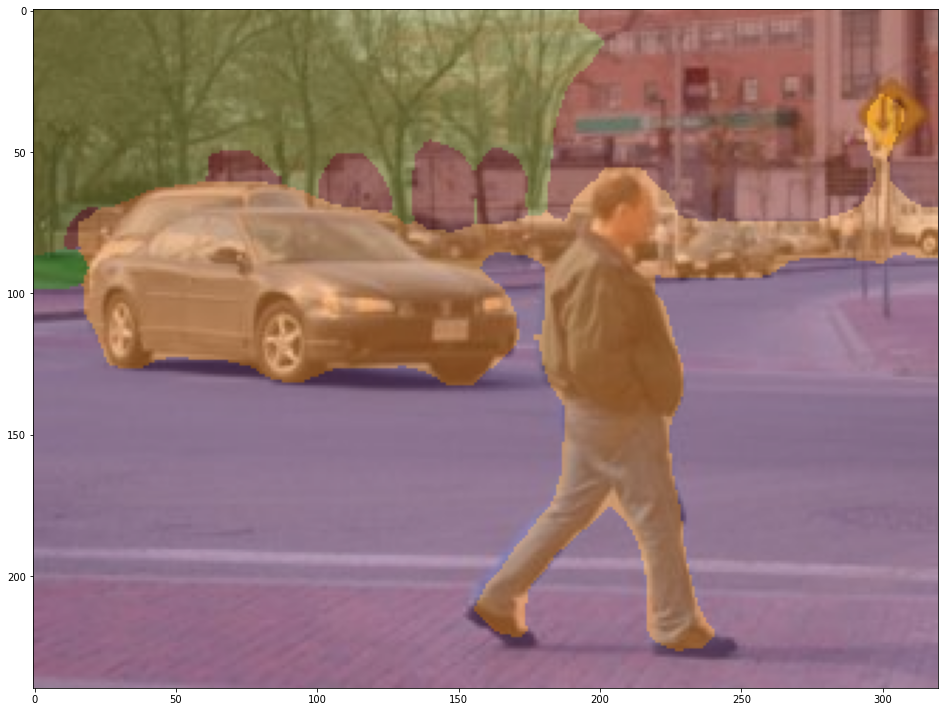

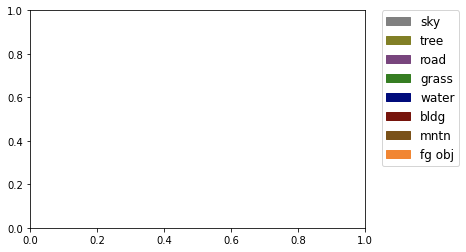

In [22]:
img = mmcv.imread('iccv09Data/images/6000124.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

# 为每一种颜色创建一个 patch 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# 将各种颜色的 patches 作为 Legen 图例中的参数 handles 输入
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()